In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.python.keras.layers import Input, Dense, Activation, Dropout, MaxPooling1D, Flatten, LSTM, Convolution1D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.utils.data_utils import get_file
from timeit import default_timer as timer 
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as scs
import random
import sys
import os
import glob

In [4]:
#user-input variables

alldata = []
filenames = ['./matlab_rng']#Specify the directory + filename of the file to be trained and tested
weightname ='matlab_rng' #Specify the name to call this set of data

# Length of input. Treating each input that consists of 100 "words" as a "sentence".
maxlen = 100 #Default is 100
# Distance between 2 consecutive "sentences"
step = 3 #Default is 3, can be increased to speed up the training. The smaller the step, the higher the accurancy

#Batch the data to relief hardware requirements. 
#Change this to smaller value if there is memory issue, or for validation. 
#The user can increase this (up to 1000000) if user's hardware permits. 
#If an error occurs due to memory, will need to re-run Step 2 due to clear memory steps in step 5
new_size = 500000

Data:matlab_rng
Mean= 127.51636
Standard Deviation= 73.91273257802337
Max-probability 0.003982


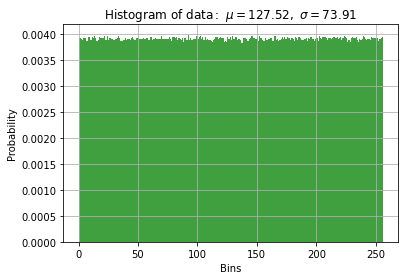

(10000000,)


In [5]:
print('Data:'+weightname)

for filename in filenames:
    data = np.fromfile(filename, dtype='<u1')  
    alldata.append(data[:10000000])

data=data[:5000000]    
mu, sigma = np.mean(data), np.std(data)
#print('Mean='(mu),'Standard Deviation=' len(sigma))
print('Mean=',mu)
print('Standard Deviation=',sigma)

# the histogram of the data
n, bins, patches = plt.hist(data, list(range(np.min(data),np.max(data)+2)), density=1, facecolor='green', alpha=0.75)
print('Max-probability',max(n))

plt.xlabel('Bins')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of \ data:}\ \mu=%.2f,\ \sigma=%.2f$' % (mu,sigma))
plt.grid(True)

plt.show()

del data  #delete data

alldata = np.concatenate(alldata)    
print(alldata.shape)

In [6]:
text = alldata[:5000000]
test1 = alldata[5000000:6000000]
test2 = alldata[6000000:7000000]
test3 = alldata[7000000:8000000]
test4 = alldata[8000000:9000000]
test5 = alldata[9000000:]
text = list(text)
test1 = list(test1)
test2 = list(test2)
test3 = list(test3)
test4 = list(test4)
test5 = list(test5)
text = map(str,text)
test1 = map(str,test1)
test2 = map(str,test2)
test3 = map(str,test3)
test4 = map(str,test4)
test5 = map(str,test5)
text_list = list(text)
test1_list = list(test1)
test2_list = list(test2)
test3_list = list(test3)
test4_list = list(test4)
test5_list = list(test5)

del text
del test1
del test2
del test3
del test4
del test5

print(len(text_list), len(test1_list), len(test5_list))

5000000 1000000 1000000


In [7]:
# Treating each number as a "word". Creating a dictionary.
alldata = alldata.astype(np.str)
chars = sorted(list(set(alldata)))

print(chars)
del alldata
print('Total words:', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '22

In [8]:
# Length of input. Treating each input that consists of 100 "words" as a "sentence".
maxlen = 100
# Distance between 2 consecutive "sentences"
step = 3

sentences = []
next_chars = []
for i in range(0, len(text_list) - maxlen, step):
    sentences.append(text_list[i: (i + maxlen)])
    next_chars.append(text_list[(i + maxlen)])
print('nb sequences:', len(sentences))


print('Start vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):        
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done vectorization!')

nb sequences: 1666634
Start vectorization...
Done vectorization!


In [9]:
# build the RCNN model
print('Build model...')
model = Sequential()
model.add(Convolution1D(filters=64, kernel_size=9, padding='same', activation='relu', input_shape=(maxlen, len(chars))))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.0005), metrics=['accuracy'])
print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
weight ='weights_'+weightname+'.hdf5'
print(weight)
monitoring = ModelCheckpoint(weight, monitor='val_loss', verbose=1, save_best_only=True)

Build model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           147520    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               

In [10]:
model.fit(X, y, epochs=50, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping,monitoring])
model.load_weights(weight)

Train on 1333307 samples, validate on 333327 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1333248/1333307 [============================>.] - ETA: 0s - loss: 5.5455 - acc: 0.0039
Epoch 00001: val_loss improved from inf to 5.54551, saving model to weights_matlab_rng.hdf5
1333307/1333307 [==============================] - 3013s 2ms/sample - loss: 5.5455 - acc: 0.0039 - val_loss: 5.5455 - val_acc: 0.0037
Epoch 2/50
1333248/1333307 [============================>.] - ETA: 0s - loss: 5.5453 - acc: 0.0041
Epoch 00002: val_loss did not improve from 5.54551
1333307/1333307 [==============================] - 3062s 2ms/sample - loss: 5.5453 - acc: 0.0041 - val_loss: 5.5456 - val_acc: 0.0039
Epoch 3/50
1333248/1333307 [============================>.] - ETA: 0s - loss: 5.5433 - acc: 0.0046
Epoch 00003: val_loss did not improve from 5.54551
1333307/1333307 [==============================] - 2963s 2ms/sample - loss: 5.5433 - acc: 0.00

In [11]:
tests = [test1_list,test2_list,test3_list,test4_list,test5_list]
del test1_list
del test2_list
del test3_list
del test4_list
del test5_list
average = 0
start = timer()
for test in tests:
    n_batch = int(len(test)/new_size)
    for ib in range(n_batch):
        test_ = test[ib*new_size:(ib+1)*new_size]
    
        maxlen = 100
        step = 1
        sentences = []
        next_chars = []
        for i in range(0, len(test_) - maxlen, step):
            sentences.append(test_[i: (i + maxlen)])
            next_chars.append(test_[(i + maxlen)])
        print('nb sequences:', len(sentences))

        print('Vectorization...')
        Xt = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
        yt = np.zeros((len(sentences), len(chars)), dtype=np.bool)
        for i, sentence in enumerate(sentences):

            for t, char in enumerate(sentence):        
                Xt[i, t, char_indices[char]] = 1       
            yt[i, char_indices[next_chars[i]]] = 1
        n_true = 0
        diversity = 1
        for i,x in enumerate(Xt):
            if i % 100000 == 0:
                print ("Processed %d %d" % (i,n_true))
            x = x.reshape(1,maxlen,-1)
            preds = model.predict(x, verbose=0)[0]
            next_index = np.argmax(preds)      
            next_char = indices_char[next_index]
            if next_char == indices_char[np.argmax(yt[i])]:
                n_true += 1
        print ("%d_%d_%.5f" % (n_true,yt.shape[0],(float(n_true)/yt.shape[0])))
        average = average + (float(n_true)/yt.shape[0])
print("Time taken: %.5f hours, P_ML = %.5f" % (float(timer()-start)/3600, average/(5*n_batch)))

nb sequences: 499900
Vectorization...
Processed 0 0
Processed 100000 363
Processed 200000 746
Processed 300000 1115
Processed 400000 1518
1884_499900_0.00377
nb sequences: 499900
Vectorization...
Processed 0 0
Processed 100000 390
Processed 200000 767
Processed 300000 1176
Processed 400000 1541
1888_499900_0.00378
nb sequences: 499900
Vectorization...
Processed 0 0
Processed 100000 425
Processed 200000 803
Processed 300000 1189
Processed 400000 1595
1962_499900_0.00392
nb sequences: 499900
Vectorization...
Processed 0 0
Processed 100000 403
Processed 200000 779
Processed 300000 1173
Processed 400000 1569
1946_499900_0.00389
nb sequences: 499900
Vectorization...
Processed 0 0
Processed 100000 384
Processed 200000 763
Processed 300000 1177
Processed 400000 1544
1927_499900_0.00385
nb sequences: 499900
Vectorization...
Processed 0 0
Processed 100000 422
Processed 200000 818
Processed 300000 1223
Processed 400000 1585
1943_499900_0.00389
nb sequences: 499900
Vectorization...
Processed 0 0
